# 第5章: 係り受け解析

日本語Wikipediaの「人工知能」に関する記事からテキスト部分を抜き出したファイルがai.ja.zipに収録されている． この文章をCaboChaやKNP等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

In [ ]:
### 初回のみ実行
!wget https://nlp100.github.io/data/ai.ja.zip
!unzip ai.ja.zip
# MeCabのインストール
!apt install mecab libmecab-dev mecab-ipadic-utf8
# CRF++のソースファイルのダウンロード・解凍・インストール
FILE_ID = "0B4y35FiV1wh7QVR6VXJ5dWExSTQ"
FILE_NAME = "crfpp.tar.gz"
!wget 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O $FILE_NAME
!tar xvf crfpp.tar.gz
%cd CRF++-0.58
!./configure && make && make install && ldconfig
%cd ..
# CaboChaのソースファイルのダウンロード・解凍・インストール
FILE_ID = "0B4y35FiV1wh7SDd1Q1dUQkZQaUU"
FILE_NAME = "cabocha-0.69.tar.bz2"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt
!tar -xvf cabocha-0.69.tar.bz2
%cd cabocha-0.69
!./configure -with-charset=utf-8 && make && make check && make install && ldconfig
%cd ..
# cabocha
!cabocha -f1 -o ai.ja.txt.parsed ai.ja.txt

## 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（`surface`），基本形（`base`），品詞（`pos`），品詞細分類1（`pos1`）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文を`Morph`オブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [ ]:
class Morph:
  def __init__(self, morph):
    surface, attr = morph.split('\t')
    attr = attr.split(',')
    self.surface = surface
    self.base = attr[6]
    self.pos = attr[0]
    self.pos1 = attr[1]

In [ ]:
filename = './ai.ja.txt.parsed'

sentences = []
morphs = []
with open(filename, mode='r') as f:
  for line in f:
    if line[0] == '*':  # 係り受け関係を表す行：スキップ
      continue
    elif line != 'EOS\n':  # 文末以外：Morphを適用し形態素リストに追加
      morphs.append(Morph(line))
    else:  # 文末：形態素リストを文リストに追加
      sentences.append(morphs)
      morphs = []

# 確認
for m in sentences[2]:
  print(vars(m))

{'surface': '人工', 'base': '人工', 'pos': '名詞', 'pos1': '一般'}
{'surface': '知能', 'base': '知能', 'pos': '名詞', 'pos1': '一般'}
{'surface': '（', 'base': '（', 'pos': '記号', 'pos1': '括弧開'}
{'surface': 'じん', 'base': 'じん', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'こうち', 'base': 'こうち', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'のう', 'base': 'のう', 'pos': '助詞', 'pos1': '終助詞'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': 'AI', 'base': '*\n', 'pos': '名詞', 'pos1': '一般'}
{'surface': '〈', 'base': '〈', 'pos': '記号', 'pos1': '括弧開'}
{'surface': 'エーアイ', 'base': '*\n', 'pos': '名詞', 'pos1': '固有名詞'}
{'surface': '〉', 'base': '〉', 'pos': '記号', 'pos1': '括弧閉'}
{'surface': '）', 'base': '）', 'pos': '記号', 'pos1': '括弧閉'}
{'surface': 'と', 'base': 'と', 'pos': '助詞', 'pos1': '格助詞'}
{'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': '「', 'base': '「', 'pos': '記号', 'pos1': '括弧開'}
{

## 41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラス`Chunk`を実装せよ．このクラスは形態素（`Morph`オブジェクト）のリスト（`morphs`），係り先文節インデックス番号（`dst`），係り元文節インデックス番号のリスト（`srcs`）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文を`Chunk`オブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [ ]:
class Chunk():
  def __init__(self, morphs, dst):
    self.morphs = morphs
    self.dst = dst
    self.srcs = []

class Sentence():
  def __init__(self, chunks):
    self.chunks = chunks
    for i, chunk in enumerate(self.chunks):
      if chunk.dst != -1:
        self.chunks[chunk.dst].srcs.append(i)

In [ ]:
filename = './ai.ja.txt.parsed'

sentences = []
chunks = []
morphs = []
with open(filename, mode='r') as f:
  for line in f:
    ### print(f'line: {line}')
    if line[0] == '*':  # 係り受け関係を表す行：直前の文節の情報にChunkを適用し文節リストに追加 + 直後の文節の係り先を取得
      if len(morphs) > 0:
        chunks.append(Chunk(morphs, dst))
        morphs = []
      dst = int(line.split(' ')[2].rstrip('D'))
    elif line != 'EOS\n':  # 文末以外：Morphを適用し形態素リストに追加
      morphs.append(Morph(line))
      ### print(f'morphs: {vars(Morph(line))}')
    else:  # 文末：直前の文節の情報にChunkを適用し文節リストに追加 + 文節リストにSentenceを適用し文リストに追加
      if 0 < len(chunks): # EOS\n が２回連続で出てきた場合に備えて
        chunks.append(Chunk(morphs, dst))
        sentences.append(Sentence(chunks))
        morphs = []
        chunks = []
        dst = None

# 確認
#'''
for chunk in sentences[0].chunks:
  print([morph.surface for morph in chunk.morphs], chunk.dst, chunk.srcs)
### '''

['人工', '知能'] -1 []
['人工', '知能'] 17 []
['（', 'じん', 'こうち', 'のう', '、', '、'] 17 []
['AI'] 3 [3]
['〈', 'エーアイ', '〉', '）', 'と', 'は', '、'] 17 []
['「', '『', '計算'] 5 [5]
['（', '）', '』', 'という'] 9 []
['概念', 'と'] 9 []
['『', 'コンピュータ'] 8 [8]
['（', '）', '』', 'という'] 9 [6, 7, 9]
['道具', 'を'] 10 [10]
['用い', 'て'] 12 []
['『', '知能', '』', 'を'] 12 [11, 12]
['研究', 'する'] 13 [13]
['計算', '機', '科学'] 14 [14]
['（', '）', 'の'] 15 [15]
['一', '分野', '」', 'を'] 16 [16]
['指す'] 17 [1, 2, 4, 17]
['語', '。'] 34 []
['「', '言語', 'の'] 20 []
['理解', 'や'] 20 [19, 20]
['推論', '、'] 21 [21]
['問題', '解決', 'など', 'の'] 22 [22]
['知的', '行動', 'を'] 24 []
['人間', 'に'] 24 [23, 24]
['代わっ', 'て'] 26 []
['コンピューター', 'に'] 26 [25, 26]
['行わ', 'せる'] 27 [27]
['技術', '」', '、', 'または', '、'] 34 []
['「', '計算', '機'] 29 [29]
['（', 'コンピュータ', '）', 'による'] 31 []
['知的', 'な'] 31 [30, 31]
['情報処理', 'システム', 'の'] 33 []
['設計', 'や'] 33 [32, 33]
['実現', 'に関する'] 34 [18, 28, 34]
['研究', '分野', '」', 'と', 'も'] 35 [35]
['さ', 'れる', '。'] -1 []


## 42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [ ]:
for sentence in sentences[:3]:
  for chunk in sentence.chunks:
    if int(chunk.dst) != -1 and int(chunk.dst) not in chunk.srcs:
      modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
      modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
      print(f'{modifier}\t{modifiee}\n係り元番号: {chunk.dst}==>係り先番号: {chunk.srcs}\n')

人工知能	指す
係り元番号: 17==>係り先番号: []

じんこうちのう	指す
係り元番号: 17==>係り先番号: []

エーアイとは	指す
係り元番号: 17==>係り先番号: []

という	という
係り元番号: 9==>係り先番号: []

概念と	という
係り元番号: 9==>係り先番号: []

用いて	知能を
係り元番号: 12==>係り先番号: []

語	実現に関する
係り元番号: 34==>係り先番号: []

言語の	理解や
係り元番号: 20==>係り先番号: []

知的行動を	人間に
係り元番号: 24==>係り先番号: []

代わって	コンピューターに
係り元番号: 26==>係り先番号: []

技術または	実現に関する
係り元番号: 34==>係り先番号: []

コンピュータによる	知的な
係り元番号: 31==>係り先番号: []

情報処理システムの	設計や
係り元番号: 33==>係り先番号: []

日本大百科全書(ニッポニカ)』の	解説で
係り元番号: 1==>係り先番号: []

解説で	述べている
係り元番号: 5==>係り先番号: [0]

情報工学者通信工学者の	佐藤理史は
係り元番号: 3==>係り先番号: []

佐藤理史は	述べている
係り元番号: 5==>係り先番号: [2]

次のように	述べている
係り元番号: 5==>係り先番号: []

人間の	知的能力を
係り元番号: 1==>係り先番号: []

知的能力を	実現する
係り元番号: 3==>係り先番号: [0]

コンピュータ上で	実現する
係り元番号: 3==>係り先番号: []

実現する	技術ソフトウェアコンピュータシステム
係り元番号: 5==>係り先番号: [1, 2]

様々な	技術ソフトウェアコンピュータシステム
係り元番号: 5==>係り先番号: []

技術ソフトウェアコンピュータシステム	ある
係り元番号: 19==>係り先番号: [3, 4]

応用例は	ある
係り元番号: 19==>係り先番号: []

自然言語処理	機械翻訳かな漢字変換構文解析等
係り元番号: 8==>係り先番号: []

機械翻訳かな漢字変換構文解析等	専門家の
係り元番号: 9==>係り先番号: [7]

専門家の	推論判断を
係り元番号:

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [ ]:
for sentence in sentences[:3]:
  for chunk in sentence.chunks:
    if int(chunk.dst) != -1 and int(chunk.dst) not in chunk.srcs:
      modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs])
      modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs])
      modifier_pos = [morph.pos for morph in chunk.morphs]
      modifiee_pos = [morph.pos for morph in sentence.chunks[int(chunk.dst)].morphs]
      if '名詞' in modifier_pos and '動詞' in modifiee_pos:
        print(f'{modifier}\t{modifiee}\n係り元番号: {chunk.dst}==>係り先番号: {chunk.srcs}\n')

人工知能	指す
係り元番号: 17==>係り先番号: []

じんこうちのう	指す
係り元番号: 17==>係り先番号: []

エーアイとは	指す
係り元番号: 17==>係り先番号: []

解説で	述べている
係り元番号: 5==>係り先番号: [0]

佐藤理史は	述べている
係り元番号: 5==>係り先番号: [2]

次のように	述べている
係り元番号: 5==>係り先番号: []

知的能力を	実現する
係り元番号: 3==>係り先番号: [0]

コンピュータ上で	実現する
係り元番号: 3==>係り先番号: []

技術ソフトウェアコンピュータシステム	ある
係り元番号: 19==>係り先番号: [3, 4]

応用例は	ある
係り元番号: 19==>係り先番号: []

推論判断を	模倣する
係り元番号: 11==>係り先番号: [9]

画像データを	解析して
係り元番号: 14==>係り先番号: []

解析して	検出抽出したりする
係り元番号: 17==>係り先番号: [13]

パターンを	検出抽出したりする
係り元番号: 17==>係り先番号: [15]

画像認識等が	ある
係り元番号: 19==>係り先番号: [12, 17]

1956年に	命名された
係り元番号: 23==>係り先番号: []

ダートマス会議で	命名された
係り元番号: 23==>係り先番号: []

ジョンマッカーシーにより	命名された
係り元番号: 23==>係り先番号: []

命名された	使われている
係り元番号: 35==>係り先番号: [19, 20, 21, 22]

現在では	使われている
係り元番号: 35==>係り先番号: []

記号処理を	用いた
係り元番号: 26==>係り先番号: []

記述を	する
係り元番号: 30==>係り先番号: [27]

主体と	する
係り元番号: 30==>係り先番号: []

意味あいでも	使われている
係り元番号: 35==>係り先番号: [33]

思考ルーチンも	呼ばれる
係り元番号: 41==>係り先番号: [37, 38]

ことも	ある
係り元番号: 43==>係り先番号: [41]



## 44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい．

In [ ]:
# 日本語表示用フォントのインストール
!apt install fonts-ipafont-gothic

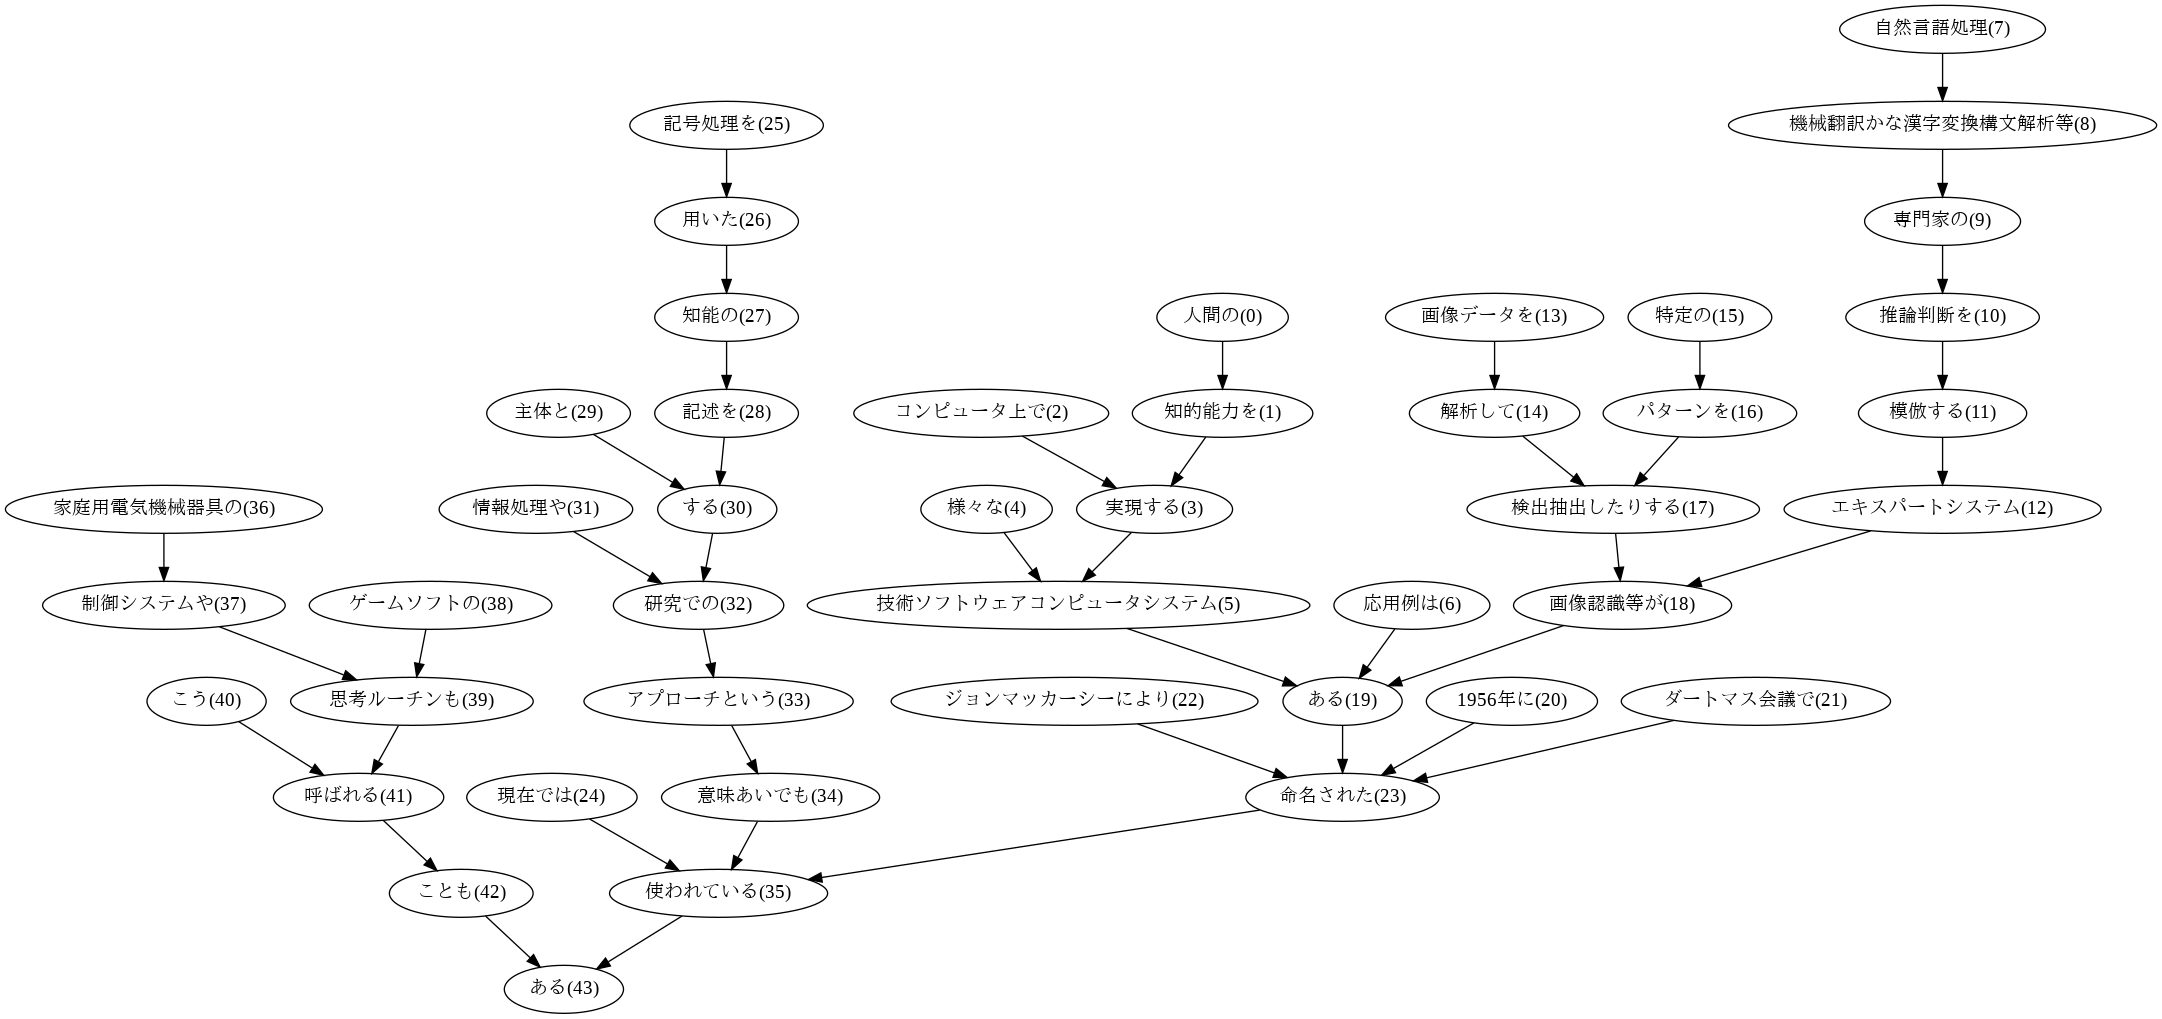

In [ ]:
import pydot
from IPython.display import Image,display_png
from graphviz import Digraph

sentence = sentences[2]
edges = []
for id, chunk in enumerate(sentence.chunks):
  if int(chunk.dst) != -1:
    modifier = ''.join([morph.surface if morph.pos != '記号' else '' for morph in chunk.morphs] + ['(' + str(id) + ')'])
    modifiee = ''.join([morph.surface if morph.pos != '記号' else '' for morph in sentence.chunks[int(chunk.dst)].morphs] + ['(' + str(chunk.dst) + ')'])
    edges.append([modifier, modifiee])
n = pydot.Node('node')
n.fontname = 'IPAGothic'
g = pydot.graph_from_edges(edges, directed=True)
g.add_node(n)
g.write_png('./nlp44.png')
display_png(Image('./nlp44.png'))

## 45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．
```
作り出す	で は を
```
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [ ]:
#with open('./ans45.txt', 'w') as f:
for sentence in sentences:
  for chunk in sentence.chunks:
    for morph in chunk.morphs:
      if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
        cases = []
        for src in chunk.srcs:  # 見つけた動詞の係り元chunkから助詞を探す
          cases = cases + [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
        if len(cases) > 0:  # 助詞が見つかった場合は重複除去後辞書順にソートして出力
          cases = sorted(list(set(cases)))
          line = '{}\t{}'.format(morph.base, ' '.join(cases))
          print(line)#, file=f)
        break

指す	と のう は
述べる	で に の は
する	で を
する	を
する	を
する	て を
ある	が は
する	で に により
用いる	を
する	と を
使う	で でも は
呼ぶ	も
ある	て も
する	を
出す	が に
する	に を
呼ぶ	と
持つ	が に
なる	が と
する	が は
知る	として は も
ある	が て に は
集める	が を
行う	に を
ある	も
する	に を
する	において
超える	を
する	て に
行く	て により
する	にかけて を
破る	も
する	が として に
なる	で と など は
呼ぶ	と は
ある	が
繰り返す	を
する	と を
基づく	に
する	と
ある	が て として は
する	を
作る	を
なす	も
する	て で に は を を通して
上回る	で を
出す	を
行う	が て で に は
でる	が
する	て で は
だす	が で を
加える	に
見せる	て において は を
広がる	が に は
行う	を
始まる	て も
する	て と
なる	が て と
する	が と
する	は を
行う	は を
する	を
もたらす	に は を
する	に
題する	と
する	に は を
築く	を
なる	に
出る	が と に関して
作り出す	で は を
する	は を
する	を
する	として は を
する	は を
行う	を
行う	に
する	として において
する	として
示す	で に は を
する	を
示す	て は を
する	は を
する	は を
示す	を
呼ぶ	と
ある	は も
する	に を
する	を
使う	に によって は
する	が に は を
上げる	が で は を
する	に
する	に は を
打つ	に を
敗れる	が で に は
する	において を
使う	のに を
省く	によって
上回る	が を
する	は を
する	が に
する	で は も
する	が に
する	が に は
適す	に
する	から に対して を
行う	を
する	が
行う	に により を
する	が
する	に を
行う	て に を
する	に を
する	を
含む	に は も
分かる	から が
する	が に
見合う	に
見出せる	が
する	から が て にとって は も
する	が に において は
進む	が
する	に につれて
する	を
至る	に
する	は
入る	に
基づく	に
する	が


## 46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

```
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```

In [ ]:
#with open('./ans46.txt', 'w') as f:
for sentence in sentences:
  for chunk in sentence.chunks:
    for morph in chunk.morphs:
      if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
        cases = []
        modi_chunks = []
        for src in chunk.srcs:  # 見つけた動詞の係り元chunkから助詞を探す
          case = [morph.surface for morph in sentence.chunks[src].morphs if morph.pos == '助詞']
          if len(case) > 0:  # 助詞を含むchunkの場合は助詞と項を取得
            cases = cases + case
            modi_chunks.append(''.join(morph.surface for morph in sentence.chunks[src].morphs if morph.pos != '記号'))
        if len(cases) > 0:  # 助詞が1つ以上見つかった場合は重複除去後辞書順にソートし、項と合わせて出力
          cases = sorted(list(set(cases)))
          line = '{}\t{}\t{}'.format(morph.base, ' '.join(cases), ' '.join(modi_chunks))
          print(line)#, file=f)
        break

指す	と のう は	じんこうちのう エーアイとは
述べる	で に の は	解説で 佐藤理史は 次のように
する	で を	知的能力を コンピュータ上で
する	を	推論判断を
する	を	画像データを
する	て を	解析して パターンを
ある	が は	応用例は 画像認識等が
する	で に により	1956年に ダートマス会議で ジョンマッカーシーにより
用いる	を	記号処理を
する	と を	記述を 主体と
使う	で でも は	現在では 意味あいでも
呼ぶ	も	思考ルーチンも
ある	て も	使われている ことも
する	を	カウンセラーを
出す	が に	人工無脳が 引き合いに
する	に を	計算機に 役割を
呼ぶ	と	エキスパートシステムと
持つ	が に	人間が 暗黙に
なる	が と	記述が 問題と
する	が は	出されるが 実現は 利用が
知る	として は も	アプローチとしては アプローチも
ある	が て に は	困難視されている 知られているが 差は 記号的明示性に
集める	が を	サポートベクターマシンが 注目を
行う	に を	経験を 元に 学習を
ある	も	手法も
する	に を	知性を 機械的に
する	において	宇宙において
超える	を	流行を
する	て に	超えて 社会に
行く	て により	登場により 浸透して
する	にかけて を	2017年にかけて ディープラーニングを
破る	も	プレイヤーも
する	が として に	MicrosoftSuphx(SuperPhoenix)」が AIとして 十段に
なる	で と など は	麻雀では 到達するなど 最先端技術と
呼ぶ	と は	人工知能は 機械学習と
ある	が	ものが
繰り返す	を	学習を
する	と を	ことを 基本と
基づく	に	経験に
する	と	ソフトコンピューティングと
ある	が て として は	関係している 手法としては ものが
する	を	これらを
作る	を	知的システムを
なす	も	試みも
する	て で に は を を通して	なされている ACT-Rでは 推論ルールを 統計的学習を 元に 生成規則を通して
上回る	で を	領域で 人工知能を
出す	を	精度を
行う	が て で に は	第3次人工知能ブームでは 出しており 研究が 盛んに
でる	が	派生が
する	て で は	行われている 最近では でて 各分野

## 47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

```
学習を行う	に を	元に 経験を
```

In [ ]:
#with open('./ans47.txt', 'w') as f:
for sentence in sentences:
  for chunk in sentence.chunks:
    for morph in chunk.morphs:
      if morph.pos == '動詞':  # chunkの左から順番に動詞を探す
        for i, src in enumerate(chunk.srcs):  # 見つけた動詞の係り元chunkが「サ変接続名詞+を」で構成されるか確認
          if len(sentence.chunks[src].morphs) == 2 and sentence.chunks[src].morphs[0].pos1 == 'サ変接続' and sentence.chunks[src].morphs[1].surface == 'を':
            predicate = ''.join([sentence.chunks[src].morphs[0].surface, sentence.chunks[src].morphs[1].surface, morph.base])
            cases = []
            modi_chunks = []
            for src_r in chunk.srcs[:i] + chunk.srcs[i + 1:]:  # 残りの係り元chunkから助詞を探す
              case = [morph.surface for morph in sentence.chunks[src_r].morphs if morph.pos == '助詞']
              if len(case) > 0:  # 助詞を含むchunkの場合は助詞と項を取得
                cases = cases + case
                modi_chunks.append(''.join(morph.surface for morph in sentence.chunks[src_r].morphs if morph.pos != '記号'))
            if len(cases) > 0:  # 助詞が1つ以上見つかった場合は重複除去後辞書順にソートし、項と合わせて出力
              cases = sorted(list(set(cases)))
              line = '{}\t{}\t{}'.format(predicate, ' '.join(cases), ' '.join(modi_chunks))
              print(line)#, file=f)
            break

記述をする	と	主体と
注目を集める	が	サポートベクターマシンが
経験を行う	に を	元に 学習を
進化を見せる	て において は	活躍している 敵対的生成ネットワークは 加えて 生成技術において
進化をいる	て において は	活躍している 敵対的生成ネットワークは 加えて 生成技術において
開発を行う	は	エイダ・ラブレスは
意味をする	に	データに
研究を進める	て	費やして
命令をする	で	機構で
運転をする	に	元に
特許をする	が に まで	2018年までに 日本が
特許をいる	が に まで	2018年までに 日本が
運転をする	て に	基づいて 柔軟に
注目を集める	から は	ことから ファジィは
制御をする	から	少なさから
研究を続ける	が て	ジェフホーキンスが 向けて
研究をいる	が て	ジェフホーキンスが 向けて
注目を集める	に	急速に
投資を行う	で に	全世界的に 民間企業主導で
探索を行う	で	無報酬で
推論をする	て	経て
研究を行う	て	始めており
研究をいる	て	始めており
投資をする	に は まで	韓国は 2022年までに
反乱を起こす	て に対して	於いて 人間に対して
監視を行う	に まで	歩行者まで 人工知能に
監視をせる	に まで	歩行者まで 人工知能に
判断を介す	から	観点から
禁止を求める	が に は	4月には ヒューマン・ライツ・ウォッチが
禁止をいる	が に は	4月には ヒューマン・ライツ・ウォッチが
追及を受ける	て で と とともに は	暴露されており 公聴会では とともに 拒否すると 整合性で
解任をする	て は	含まれており Google社員らは
解散をする	が で は	Googleは 倫理委員会が 理由で
話をする	は	哲学者は
話をいる	は	哲学者は
議論を行う	まで	これまで
議論をくる	まで	これまで


## 48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した
```

In [ ]:
sentence = sentences[2]
for chunk in sentence.chunks:
  if '名詞' in [morph.pos for morph in chunk.morphs]:  # chunkが名詞を含むか確認
    path = [''.join(morph.surface for morph in chunk.morphs if morph.pos != '記号')]
    while chunk.dst != -1:  # 名詞を含むchunkを先頭に、dstを根まで順に辿ってリストに追加
      path.append(''.join(morph.surface for morph in sentence.chunks[chunk.dst].morphs if morph.pos != '記号'))
      chunk = sentence.chunks[chunk.dst]
    print(' -> '.join(path))

人間の -> 知的能力を -> 実現する -> 技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
知的能力を -> 実現する -> 技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
コンピュータ上で -> 実現する -> 技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
実現する -> 技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
様々な -> 技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
技術ソフトウェアコンピュータシステム -> ある -> 命名された -> 使われている -> ある
応用例は -> ある -> 命名された -> 使われている -> ある
自然言語処理 -> 機械翻訳かな漢字変換構文解析等 -> 専門家の -> 推論判断を -> 模倣する -> エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
機械翻訳かな漢字変換構文解析等 -> 専門家の -> 推論判断を -> 模倣する -> エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
専門家の -> 推論判断を -> 模倣する -> エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
推論判断を -> 模倣する -> エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
模倣する -> エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
エキスパートシステム -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
画像データを -> 解析して -> 検出抽出したりする -> 画像認識等が -> ある -> 命名された -> 使われている -> ある
解析して -> 検出抽出したりする -> 画像認識等が -> ある -> 命名された -> 使われている -> ある


## 49. 名詞間の係り受けパスの抽出

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を”` -> `“で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．
- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを
```

In [ ]:
from itertools import combinations
import re

sentence = sentences[2]
nouns = []
for i, chunk in enumerate(sentence.chunks):
  if '名詞' in [morph.pos for morph in chunk.morphs]:  # 名詞を含む文節を抽出
    nouns.append(i)
for i, j in combinations(nouns, 2):  # 名詞を含む文節のペアごとにパスを作成
  path_i = []
  path_j = []
  while i != j:
    if i < j:
      path_i.append(i)
      i = sentence.chunks[i].dst
    else:
      path_j.append(j)
      j = sentence.chunks[j].dst
  if len(path_j) == 0:  # 1つ目のケース
    chunk_X = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence.chunks[path_i[0]].morphs])
    chunk_Y = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence.chunks[i].morphs])
    chunk_X = re.sub('X+', 'X', chunk_X)
    chunk_Y = re.sub('Y+', 'Y', chunk_Y)
    path_XtoY = [chunk_X] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_i[1:]] + [chunk_Y]
    print(' -> '.join(path_XtoY))
  else:  # 2つ目のケース
    chunk_X = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence.chunks[path_i[0]].morphs])
    chunk_Y = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence.chunks[path_j[0]].morphs])
    chunk_k = ''.join([morph.surface for morph in sentence.chunks[i].morphs])
    chunk_X = re.sub('X+', 'X', chunk_X)
    chunk_Y = re.sub('Y+', 'Y', chunk_Y)
    path_X = [chunk_X] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_i[1:]]
    path_Y = [chunk_Y] + [''.join(morph.surface for morph in sentence.chunks[n].morphs) for n in path_j[1:]]
    print(' | '.join([' -> '.join(path_X), ' -> '.join(path_Y), chunk_k]))

Xの -> Yを
Xの -> 知的能力を | Yで | 実現する、
Xの -> 知的能力を -> Yする、
Xの -> 知的能力を -> 実現する、 | Yな | 技術・ソフトウェア・コンピュータシステム。
Xの -> 知的能力を -> 実現する、 -> Y・Y・Y。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yは | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Y -> （機械翻訳・かな漢字変換・構文解析等）、 -> 専門家の -> 推論・判断を -> 模倣する -> エキスパートシステム、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | （Y・Y・Y）、 -> 専門家の -> 推論・判断を -> 模倣する -> エキスパートシステム、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yの -> 推論・判断を -> 模倣する -> エキスパートシステム、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Y・Yを -> 模倣する -> エキスパートシステム、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yする -> エキスパートシステム、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Y、 -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yを -> 解析して -> 検出・抽出したりする -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yして -> 検出・抽出したりする -> 画像認識等が | ある。
Xの -> 知的能力を -> 実現する、 -> 技術・ソフトウェア・コンピュータシステム。 | Yの